<div align="center"; span style="color:#336699"><b><h2>Chapter 5.2 - Filtering Precipitation Systems by Duration and Area Thresholds</h2></b></div>
<hr style="border:2px solid #0077b9;">
<br/>
<div style="text-align: center;font-size: 90%;">
   <sup><a href="https://www.linkedin.com/in/helvecio-leal/"> Helvecio B. Leal Neto, <i class="fab fa-lg fa-orcid" style="color: #a6ce39"></i></a></sup><t>&nbsp;</t>
    <sup><a href="https://www.linkedin.com/in/alan-calheiros-64a252160/">Alan J. P. Calheiros, <i class="fab fa-lg fa-orcid" style="color: #a6ce39"></i></a></sup>
   <br/><br/>
    National Institute for Space Research (INPE)
    <br/>
    Avenida dos Astronautas, 1758, Jardim da Granja, São José dos Campos, SP 12227-010, Brazil
    <br/><br/>
    Contact: <a href="mailto:helvecio.neto@inpe.br">helvecio.neto@inpe.br</a>, <a href="mailto:alan.calheiros@inpe.br">alan.calheiros@inpe.br</a>
    <br/><br/>
    Last Update: December 2, 2024
</div>
<br/>
<div style="text-align: justify;  margin-left: 25%; margin-right: 25%;">
<b>Abstract.</b> This Jupyter Notebook is part of Doctoral Thesis of Helvecio B. Leal Neto and performs statistical analysis of tracked precipitation systems from GSMaP-MKV v8 and IMERG Final V07 datasets. The analysis focuses on filtering systems based on precipitation intensity thresholds and characterizing their duration and area distributions. This filtering step is essential to identify and classify precipitation systems according to their temporal and spatial characteristics, allowing for comparative analysis between different satellite precipitation products.
</div>    
<br/>
<div style="text-align: justify;  margin-left: 15%; margin-right: 15%;font-size: 75%; border-style: solid; border-color: #0077b9; border-width: 1px; padding: 5px;">
    <b>In this analysis, we compute statistics for tracked precipitation systems (PSs) from two satellite products, examining their distribution across different duration classes and calculating mean areas with associated variability. The results reveal the frequency distribution of short-lived versus long-lived systems and their characteristic spatial scales.
</b>
</div>

### Schedule
 [1. Environment Setup and Library Imports](#setup)<br>
 [2. Database Configuration](#database)<br>
 [3. Data Path Configuration](#paths)<br>
 [4. GSMaP Statistics Calculation](#gsmap)<br>
 [5. IMERG Statistics Calculation](#imerg)<br>
 [6. Comparative Visualization](#visualization)

<a id='setup'></a>
#### 1. Environment Setup and Library Imports

This section initializes the notebook environment and imports all necessary libraries:

- **autoreload**: Automatically reloads modules when they change, useful for development with custom modules
- **glob**: File pattern matching for locating tracking table parquet files
- **filters**: Custom module containing functions for calculating precipitation system statistics
- **plots**: Custom module for visualization functions specialized in precipitation system analysis
- **utils.createDuckCon**: Utility function to create and configure DuckDB database connections
- **matplotlib.pyplot**: Library for creating static, animated, and interactive visualizations in Python
- **numpy**: Fundamental package for scientific computing with Python

The autoreload extension ensures that changes to the custom modules (`filters.py`, `plots.py`, `utils.py`) are immediately reflected without needing to restart the kernel.

In [2]:
%reload_ext autoreload
%autoreload 2
import glob
import filters
import plots
import matplotlib.pyplot as plt
import numpy as np
from utils import createDuckCon

<a id='database'></a>
#### 2. Database Configuration

Initialize a DuckDB database connection for efficient querying of large parquet datasets.

DuckDB provides high-performance analytical capabilities with SQL-like queries, making it ideal for processing the large tracking tables containing precipitation system data. The `createDuckCon()` function sets up the connection with appropriate configurations for spatial operations and progress monitoring.

In [3]:
con = createDuckCon()

<a id='paths'></a>
#### 3. Data Path Configuration

Define the file paths to the tracking tables for both satellite precipitation products:

- **GSMaP-MKV v8**: Global Satellite Mapping of Precipitation - Microwave-IR Combined Product version 8
- **IMERG Final V07**: Integrated Multi-satellitE Retrievals for GPM (Global Precipitation Measurement) Final Run version 07

Both datasets contain tracked precipitation systems stored in Parquet format, with each file representing a portion of the temporal coverage. The wildcard pattern (`*.parquet`) allows reading all files in the directory.

In [4]:
# Set path to tracking table
GSMAP_V8_TRK_TBL = '/prj/cptec/helvecio.leal/tracks/gsmap/track/trackingtable/*.parquet'
IMERG_V7_TRK_TBL = '/prj/cptec/helvecio.leal/tracks/imerg/track/trackingtable/*.parquet'

#### 3.1. List Tracking Table Files

Retrieve the complete list of parquet files for each dataset using glob pattern matching.

The files are sorted to ensure chronological processing. This step verifies that the specified paths are correct and allows inspection of the temporal coverage by examining the first and last files in each dataset.

In [5]:
# Get the list of tracking files
GSMAP_V8_TRK_FILES = sorted(glob.glob(GSMAP_V8_TRK_TBL))
IMERG_V7_TRK_FILES = sorted(glob.glob(IMERG_V7_TRK_TBL))

#### 3.2. Verify File Paths

Display the first and last file paths for both datasets to confirm proper file discovery and validate the temporal coverage.

This verification step helps ensure that the glob patterns correctly identified all tracking table files and that the datasets span the expected time periods.

In [6]:
# Print first and last file paths for verification
print(f'GSMAP V8 first file: {GSMAP_V8_TRK_FILES[0]}')
print(f'GSMAP V8 last file: {GSMAP_V8_TRK_FILES[-1]}')
print('---')
print(f'IMERG V7 first file: {IMERG_V7_TRK_FILES[0]}')
print(f'IMERG V7 last file: {IMERG_V7_TRK_FILES[-1]}')

GSMAP V8 first file: /prj/cptec/helvecio.leal/tracks/gsmap/track/trackingtable/20150101_0000.parquet
GSMAP V8 last file: /prj/cptec/helvecio.leal/tracks/gsmap/track/trackingtable/20241231_2300.parquet
---
IMERG V7 first file: /prj/cptec/helvecio.leal/tracks/imerg/track/trackingtable/20150101_0000.parquet
IMERG V7 last file: /prj/cptec/helvecio.leal/tracks/imerg/track/trackingtable/20241231_2330.parquet


<a id='gsmap'></a>
#### 4. GSMaP Statistics Calculation

Calculate comprehensive statistics for GSMaP-MKV v8 precipitation systems using a 0.1 mm/h precipitation threshold:

**Processing Steps**:
1. **Threshold Filtering**: Select only systems with precipitation rates ≥ 0.1 mm/h
2. **Duration Aggregation**: Group systems by their total duration (lifetime)
3. **Statistical Metrics**: For each duration class, calculate:
   - Count of unique systems (uid_count)
   - Percentage of total systems
   - Mean area (mean_size)
   - Standard deviation of area (std_size)
4. **Caching**: Results are saved to parquet files in `filters/gsmap/` for future use

**The `calculate_stats` function**:
- Uses DuckDB for efficient SQL-based aggregation
- Implements a caching mechanism to avoid recomputing statistics
- Groups precipitation systems by their final duration
- Computes area statistics from all timesteps of each system

This analysis provides insights into the distribution of precipitation system lifetimes and their characteristic spatial scales in the GSMaP dataset.

In [7]:
#Filter tracks with threshold 0.1 and save statistics
gsmap_statistics = filters.calculate_stats(GSMAP_V8_TRK_FILES, con, threshold=0.1, save_path='filters/gsmap/')

Loading existing stats from filters/gsmap/calculate_stats_0.1.parquet


#### 4.1. Display GSMaP Statistics Table

Preview the calculated statistics for GSMaP precipitation systems.

The resulting DataFrame contains:
- **duration**: System lifetime in minutes
- **uid_count**: Number of systems with that duration
- **percentage**: Proportion of total systems (%)
- **mean_size**: Average system area in pixels
- **std_size**: Standard deviation of system area

This table reveals the frequency distribution across different duration classes and the characteristic sizes of precipitation systems in the GSMaP dataset.

In [14]:
gsmap_statistics['duration'] = gsmap_statistics['duration'] + 60  # Include the starting hour
gsmap_statistics['duration'] = gsmap_statistics['duration'] / 60  # Convert duration from minutes to hours
gsmap_statistics

,duration,uid_count,percentage,mean_size,std_size
0,1.0,59197351,73.44,36.35,128.53
1,2.0,10670375,13.24,56.58,174.19
2,3.0,4332178,5.37,68.56,197.84
3,4.0,2250193,2.79,82.74,226.05
4,5.0,1275788,1.58,101.20,264.32
...,...,...,...,...,...
337,455.0,1,0.00,6033.42,4360.64
338,466.0,1,0.00,6974.84,5428.99
339,495.0,1,0.00,1753.03,1286.49
340,548.0,1,0.00,1926.71,902.05


<a id='imerg'></a>
#### 5. IMERG Statistics Calculation

Calculate comprehensive statistics for IMERG Final V07 precipitation systems using the same 0.1 mm/h threshold:

**Processing Configuration**:
- **Threshold**: 0.1 mm/h precipitation rate
- **Output Directory**: `results/imerg/`
- **Same Methodology**: Identical to GSMaP processing for direct comparison

The IMERG dataset has higher temporal resolution (30-minute) compared to GSMaP (1-hour), which may result in different duration distributions and system counts. This parallel processing enables comparative analysis between the two satellite precipitation products.

In [9]:
# Filter IMERG tracks with threshold 0.1 and save statistics
imerg_statistics = filters.calculate_stats(IMERG_V7_TRK_FILES, con, threshold=0.1, save_path='filters/imerg/')

Loading existing stats from filters/imerg/calculate_stats_0.1.parquet


#### 5.1. Display IMERG Statistics Table

Preview the calculated statistics for IMERG precipitation systems.

The DataFrame structure is identical to the GSMaP results, containing duration classes, system counts, percentages, and area statistics. The finer temporal resolution of IMERG (30-minute vs 1-hour for GSMaP) may reveal differences in the detection and characterization of short-lived precipitation systems.

In [13]:
imerg_statistics['duration'] = imerg_statistics['duration'] + 30  # Include the starting hour
imerg_statistics['duration'] = imerg_statistics['duration'] / 60  # Convert duration from minutes to hours
imerg_statistics

,duration,uid_count,percentage,mean_size,std_size
0,0.5,82515627,54.62,27.64,155.04
1,1.0,23703273,15.69,36.72,186.45
2,1.5,13679274,9.05,39.89,186.72
3,2.0,8180858,5.42,44.94,203.43
4,2.5,5443496,3.60,48.88,209.45
...,...,...,...,...,...
714,528.0,1,0.00,10872.00,5740.68
715,532.5,1,0.00,8820.67,7696.44
716,563.5,1,0.00,22607.26,12842.18
717,587.5,1,0.00,6522.70,8804.71


<a id='visualization'></a>
#### 6. Comparative Visualization of System Distributions

Figure comparing precipitation system characteristics between GSMaP and IMERG datasets.

**Figure Configuration**:
- **Panel (a)**: GSMaP-MKV v8 results
- **Panel (b)**: IMERG Final V07 results
- **Figure Size**: 12×12 inches at 100 DPI
- **X-axis**: System duration in hours (up to 24 hours)

**Visualization Elements** (for each panel):

1. **Primary Plot (Blue Line with Circles)**:
   - **Variable**: Count of tracked precipitation systems (log scale)
   - **Style**: Dashed line with white-filled circle markers
   - **Annotations**: Percentage labels showing the proportion of total systems for each duration class
   - **Background Shading**:
     - Light red (coral): Short-lived systems (< 2 hours)
     - Light green: Medium to long-lived systems (≥ 2 hours)

2. **Secondary Plot (Gray Triangles with Error Bars)**:
   - **Variable**: Mean system area (×10³ km²)
   - **Error Bars**: ±1 standard deviation showing area variability
   - **Purpose**: Reveals relationship between system duration and spatial extent

**Analysis Focus**:
The visualization enables direct comparison of:
- Frequency distributions across duration classes
- Proportion of short-lived vs. persistent systems
- Characteristic area scales for different durations
- Differences between the two satellite products in detecting and tracking precipitation systems

**Key Findings to Observe**:
- Both datasets typically show exponential decay in system counts with increasing duration
- Short-lived systems (< 2 hours) dominate the total population
- Mean area generally increases with duration, as longer-lived systems tend to be larger
- Differences between GSMaP and IMERG may reflect their distinct temporal resolutions and retrieval algorithms

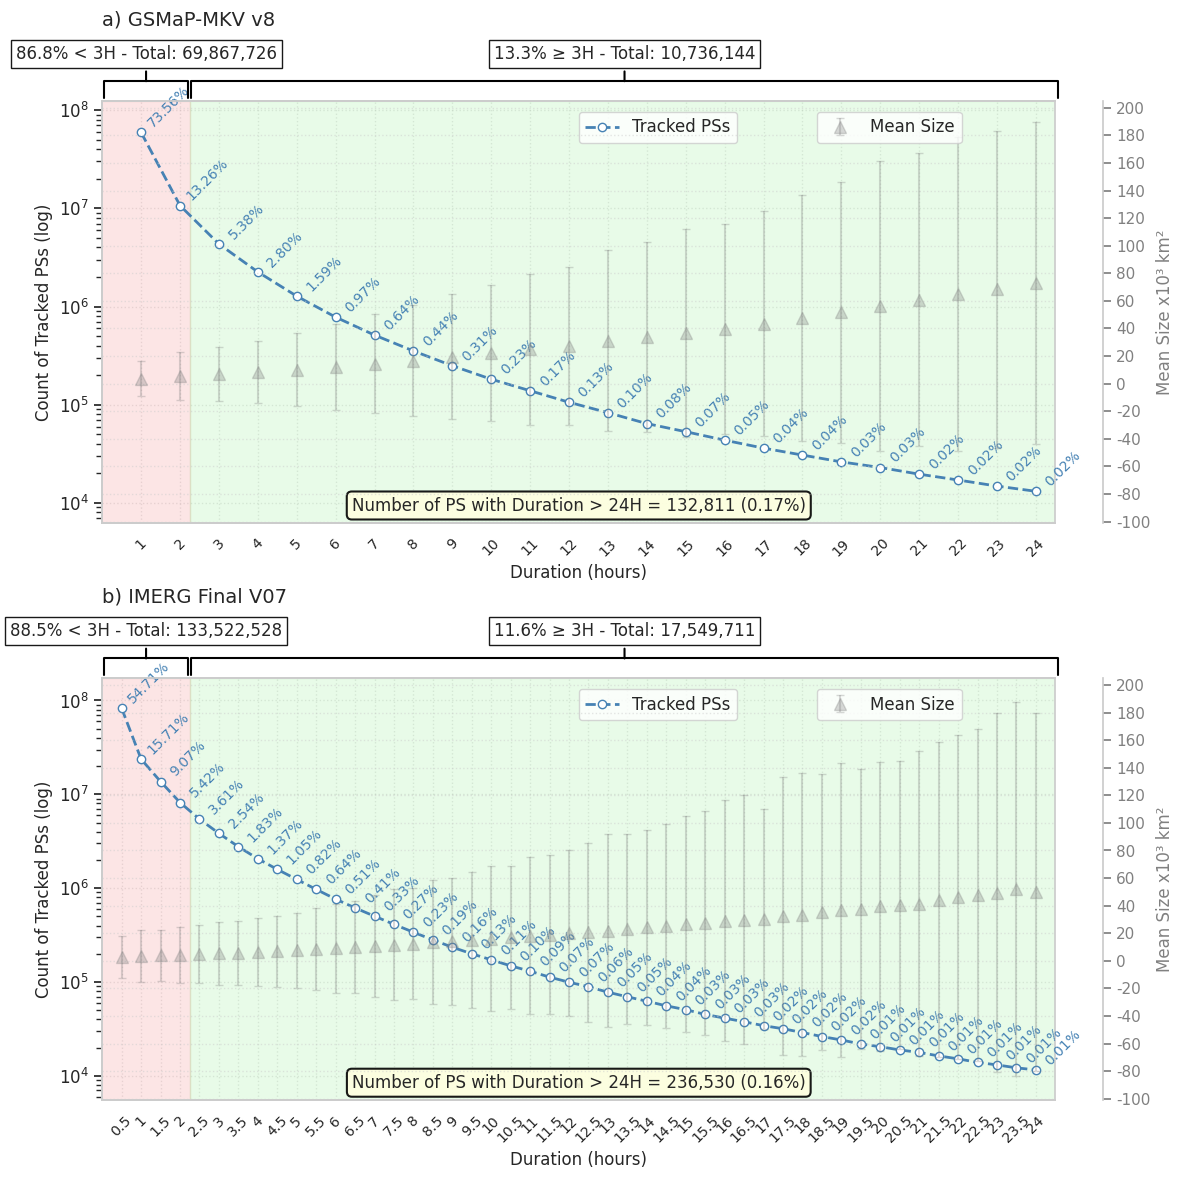

In [15]:
fig, axes = plt.subplots(2, 1, figsize=(12, 12), dpi=100)

plots.countSystemsArea(gsmap_statistics, ax1=axes[0])
plots.countSystemsArea(imerg_statistics, ax1=axes[1])

axes[0].set_title("a) GSMaP-MKV v8", loc='left', y=1.16, fontsize=14)
axes[1].set_title("b) IMERG Final V07", loc='left', y=1.16, fontsize=14)

plt.tight_layout(h_pad=0.0001)
plt.show()